In [1]:
from IPython.core.display import display 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#GlobalFinMonthly
url="https://raw.githubusercontent.com/amoreira2/Lectures/main/assets/data/GlobalFinMonthly.csv"

Data = pd.read_csv(url,na_values=-99)
# tell python Date is date:
Data['Date']=pd.to_datetime(Data['Date'])
# set an an index
Data=Data.set_index(['Date'])
Data=Data.rename(columns={Data.columns[1]: "MKTUS",Data.columns[2]: "BondUS",
                          Data.columns[3]: "EM",Data.columns[4]: "MKTxUS",Data.columns[5]: "BondxUS" })
Re=(Data.drop('RF',axis=1)).subtract(Data['RF'],axis='index')


# Estimation Uncertainty






* Investment managers rarely apply the Markowitz framework in it's more pure form as studied in Chapter 9

* Pension funds typically use a 60/40 equity/bond allocation 

* Why not used more often? 

* It requires specifying expected return assumption for entire universe of assets

* Mean-variance optimization weights heavily on assets that have extreme average returns in the sample and with attractive covariance properties, i.e., high correlation with asset yielding slightly different return

* What problems that might cause?

* The key problem is that we are dealing with a limited sample of data

* We are interested in finding the ex-ante tangency portfolio

* But the basic MV analysis identifies the ex-post tangency portfolio, i.e. a portfolio that did well in the sample, but it can be a statistical fluke

> How to evaluate the amount of uncertainty and it’s impact on our results?


 
 







* We will start by evaluating the uncertainty regarding our average expected excess return estimates for each asset

* We will then show how the weights change as we pertubate these estimates in a way that is consistent with the amount of uncertainty

* We will then show how sensitive the benefits of international diversification are

**Standard erros of average estimators**

* If observations are serially uncorrelated over time then the standard deviation of a sample average is simply

$$std\left(\sum_i^N\frac{x_i}{N}\right)=\frac{std(x_i)}{\sqrt{N}}$$

* Returns of most *liquid* assets are sufficiently close to uncorrelated over time for this assumption to be ok
    
    - It is also easy enough to adjust for serial correlation which we can easily do usign a regression library

* This measures how uncertain we are about the sample mean

* For example, there is a 5% probability that the actual mean is $E[x_i]\leq\overline{x_i}-1.64{std(\overline{x_i})}$

* So $std(\overline{x_i})$ gives a measure of how close our estimate is likely to be to true expected value

* Lets compare the sample average and the sample average standard deviation for our assets

In [2]:
Re.head()

,MKTUS,BondUS,EM,MKTxUS,BondxUS
Date,,,,,
1963-02-28,-0.0238,-0.004178,0.095922,-0.005073,NaN
1963-03-31,0.0308,0.001042,0.011849,-0.001929,-0.000387
1963-04-30,0.0451,-0.004343,-0.149555,-0.005836,0.005502
1963-05-31,0.0176,-0.004207,-0.014572,-0.002586,0.002289
1963-06-30,-0.0200,-0.000634,-0.057999,-0.013460,0.000839


In [3]:
# First we get the total number of observations and store it as `T`
T=Re.shape[0]
T

647

In [4]:
# (1) standard deviation of the sample average of excess return for each asset
avg_std=(Re.std()/(T**0.5))

# (2) sample average of excess return for each asset
avg=Re.mean()

# (3) save as ERstd (excess return standard deviation)
ERstd=pd.concat([avg_std,avg],axis=1)
#(4) rename columns
ERstd=ERstd.rename(columns={0:'avg_std',1:'avg'})
# report annualized and in percent


In [5]:
6.18+2*1.64

9.459999999999999

* Note that our data set has  50 years of data, there is still considerable uncertainty, specially for bonds

In [6]:
#number of years
T/12

53.916666666666664

So lets plot the average for each asset with the 10% confidence interval

Becasue the average estimator is normal distributed in long enough samples we can say that there is a 90% probability that this interval plotted below contains the true expected excess reutrn of these assets


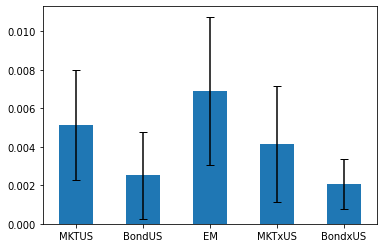

In [7]:
(ERstd).avg.plot.bar(yerr=ERstd.avg_std*1.64,  capsize=4, rot=0);

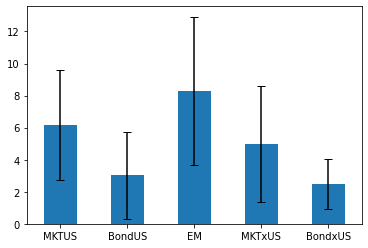

In [8]:
# lets annualize it
(ERstd.avg*12*100).plot.bar(yerr=ERstd.avg_std*1.64*12*100,  capsize=4, rot=0);

A noteworthy aspect of this estimate is that it has a really long sample it is really hard to reject the hypothesis that all these assets have exactly the same premium!

And these are all very diversified portfolios!

The problem is MUCH MORE severe once you look at individual asset which have both shorter samples and more volatile returns

The result are extremely wide confidence bands

As an example lets look at Bitcoin



---------------------------
*Bitcoin example*

We will get the Bitcoin price series from Coinbase (there are many prices of Bitcoin depending on the exchange)



<AxesSubplot:>

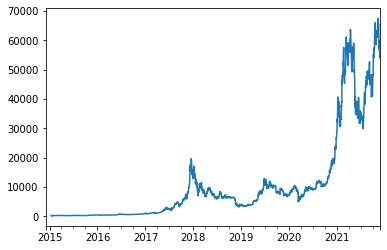

In [9]:
from fredapi import Fred
fred = Fred(api_key='f9207136b3333d7cf92c07273f6f5530')
BTC = fred.get_series('CBBTCUSD')
BTC.plot()

The issue with a new asset is that we only talk about it becasue it had high returns

No one talks about a NEW asset that has very low returns--it simply disappears

The name for this bias is **SURVIVORSHIP** bias and it plagues all our analysis

For example, why do we talk about Warren Buffet being a genious--> because he did well. But how do you know that it is not jsut luck?

We can't jsut look at the data because we don't know the 1000's of Warren buffets that never made it

So the way to deal with this  is to look at the performance **AFTER** an asset/strategy/manager become famous

In the context of strategies we call this the **Publication bias**--which we will discuss later

But for now, we will simply use google trends to figure out when Bitcoin went mainstream

<AxesSubplot:xlabel='date'>

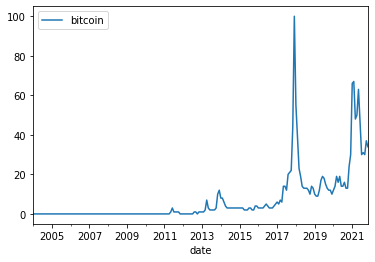

In [10]:

from pytrends.request import TrendReq
pytrend = TrendReq()
pytrend.build_payload(kw_list=['bitcoin'],timeframe='all')
Googletrends=pytrend.interest_over_time()
Googletrends.plot()

So this says end of 2017. So I will start the sample in 2018.

So the way we will do this is to compute daily returns and then covert to monthly by multiplying by the average number of trading days in a month (21)

In [11]:
RBTC=BTC.pct_change()
start='2018'
ERstd.at['BTC','avg']=RBTC[start:].mean()*21
ERstd.at['BTC','avg_std']=(RBTC[start:].std()/RBTC[start:].shape[0]**0.5)*21

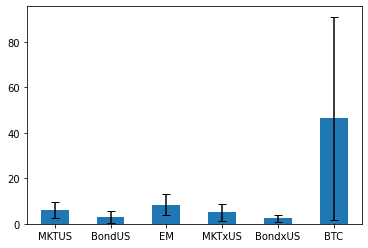

In [12]:
(ERstd.avg*12*100).plot.bar(yerr=ERstd.avg_std*1.64*12*100,  capsize=4, rot=0);

In [13]:
ERstd*12*100

,avg_std,avg
MKTUS,2.082192,6.168408
BondUS,1.652384,3.027184
EM,2.813385,8.307944
MKTxUS,2.203549,4.978818
BondxUS,0.951332,2.464985
BTC,27.189478,46.409588


So you can see that the confidence interval is just huge and you cannot really reject that is the same as the other assets.

**Why this matters (A LOT)**

We will briefly discuss statistical tests, but you should look at Chapter 20 where these issues are discussed in depth, but before going there it is important to emphasize why this is the core of quantitative investing.

- The fact that these averages are so difficult to  estimate means that our average estimator will vary a lot over time as we get more data

- It means that the past average is a very noisy proxy for what you expect to get goign forward

- It means that the in sample Sharpe ratios that you compute using the mean-variance optimizaiton will be **extremely** biased upwards because our maximizer will assume that these expected return differences across assets are true with certainty

- thus the maximum Sharpe ratio that comes from this will rely on taking extreme bets by goign long and short a few assets.

- If in fact the differences are nto real, the end portfolio will jsut be super risky, but without much expected return to show

- Of course, in the particular sample things will look great because you are evalauting the "strategy" in the same sample that you used to estimate the moments of the returns which is the key imput for your optimization.

- OF course, in REAL LIFE you don't get to do do that! You have to trade using only past data. 

- When we do that, our analysis is suffering from **look-ahead bias** because our estiamtor is using the full sample to estiamte the weights and implicily giving the trader this information

**How sensitive are our Mean-Variance portfolio to estimation uncertainty about expected excess returns?**

There are a few ways to get at that.

1. We will start by changing our expected returns asset by asset by 1 standard deviation below/above the sample average and will look how our weights change

   - There is a 32% chance that the actual expected return is actually further than the sample mean that this pertubation would imply
   - Thus this is not a very conservative exercise. MV analysis is fairly likely to be substantially more wrong than this
   - And of course we will do asset by asset to keep the intuition simple to grasp, but note that in all likelihood all assets have expected returns further from the sample. 
   - In the end that is what you actually care about, how you are wrong overall
   
2. We will then fix our weights and pertubate the average returns of the asset when we compute the performance of our strategy. 
   - We will focus only on average reutrns here becasue we will assume no uncertainty about the covariance matrix

**Optimal Weights senstivity to uncertainty**

In [16]:
# lets look at what happens with weights and Sharpes as we pertubate the mean of the market return by one standard deviation
Wmve=pd.DataFrame([],index=Re.columns)

ERe=Re.mean()
CovRe=Re.cov()
T=Re.shape[0]

asset='MKTUS'
pertubation=1
mu=Re[asset].mean()
musigma=Re[asset].std()/T**0.5
# I am creating a copy of the average return vector so I can pertubate it below 
ERemsig=ERe.copy()

ERemsig[asset]=mu-pertubation*musigma

# mve for sample mean
Wmve['samplemean'] =np.linalg.inv(CovRe) @ ERe
# mve for perturbed mean
Wmve[asset+'-'+str(pertubation)+'std'] =np.linalg.inv(CovRe) @ ERemsig
Wmve


,samplemean,MKTUS-1std
MKTUS,1.835334,0.296359
BondUS,1.423373,1.706476
EM,1.605223,1.836827
MKTxUS,-1.026421,-0.221975
BondxUS,3.365823,2.913552


In [15]:
Wmve/Wmve.sum().abs()

,samplemean,EM--2std
MKTUS,0.254790,0.153185
BondUS,0.197599,0.230149
EM,0.222844,0.478254
MKTxUS,-0.142493,-0.294310
BondxUS,0.467259,0.432721


In [34]:
# lets now loop though all assets
Wmve=pd.DataFrame([],index=Re.columns)

ERe=Re.mean()
CovRe=Re.cov()
T=Re.shape[0]
ERemsig=ERe.copy()
pertubation=1
for asset in Re.columns:
    
    mu=Re[asset].mean()
    musigma=Re[asset].std()/T**0.5
    # It is essential that I reinnitalize this vector of expected returns at the average value, otherwise as I more though
    # the floor loop I would not be changing one asset at a time, but instead I woudl be doing cumulative changes
    # because the earlier pertubations would stay in the vector
    ERemsig=ERe.copy()
    ERemsig[asset]=mu-pertubation*musigma

    # mve for sample mean
    Wmve['samplemean'] =np.linalg.inv(CovRe) @ ERe
    # mve for perturbed mean
    Wmve[asset+'-'+str(pertubation)+'std'] =np.linalg.inv(CovRe) @ ERemsig
Wmve_minus=Wmve.copy()
Wmve_minus

,samplemean,MKTUS-1std,BondUS-1std,EM-1std,MKTxUS-1std,BondxUS-1std
MKTUS,0.254790,0.045376,0.303265,0.313283,0.344091,0.304480
BondUS,0.197599,0.261279,0.000796,0.178860,0.134800,0.392717
EM,0.222844,0.281237,0.219292,0.075806,0.270653,0.298489
MKTxUS,-0.142493,-0.033987,-0.192045,-0.055092,-0.393407,-0.057789
BondxUS,0.467259,0.446095,0.668693,0.487143,0.643864,0.062102


In [35]:
# we can also pertubate in the other direction

Wmve=pd.DataFrame([],index=Re.columns)

ERe=Re.mean()
CovRe=Re.cov()
T=Re.shape[0]

pertubation=1
for asset in Re.columns:
    ERemsig=ERe.copy()
    mu=Re[asset].mean()
    musigma=Re[asset].std()/T**0.5
    #I cnahged the minus to plus in the line below
    ERemsig[asset]=mu+pertubation*musigma

    # mve for sample mean
    Wmve['samplemean'] =np.linalg.inv(CovRe) @ ERe
    # mve for perturbed mean
    Wmve[asset+'+'+str(pertubation)+'std'] =np.linalg.inv(CovRe) @ ERemsig
Wmve_plus=Wmve.copy()
Wmve_plus

,samplemean,MKTUS+1std,BondUS+1std,EM+1std,MKTxUS+1std,BondxUS+1std
MKTUS,0.254790,0.428461,0.211543,0.201659,0.149122,0.225444
BondUS,0.197599,0.144788,0.373177,0.214620,0.271908,0.082369
EM,0.222844,0.174418,0.226014,0.356403,0.166274,0.178171
MKTxUS,-0.142493,-0.232478,-0.098284,-0.221881,0.154408,-0.192516
BondxUS,0.467259,0.484811,0.287550,0.449199,0.258288,0.706532


Lets normalize the weights so the add up to one and we can visualize things better

**BE CAREFUL**

We can do that as long the weights add up to a positive number which happens to be true in this case. 

If they add up to a negative number, you will be fliping the direction of thw weights when you do such a nomralization, so it might be safer to normalize by the absolute value of the sum to preserve the sign of the weigths

In [36]:
display(Wmve_plus/Wmve_plus.sum())
display(Wmve_minus/Wmve_minus.sum())

,samplemean,MKTUS+1std,BondUS+1std,EM+1std,MKTxUS+1std,BondxUS+1std
MKTUS,0.254790,0.428461,0.211543,0.201659,0.149122,0.225444
BondUS,0.197599,0.144788,0.373177,0.214620,0.271908,0.082369
EM,0.222844,0.174418,0.226014,0.356403,0.166274,0.178171
MKTxUS,-0.142493,-0.232478,-0.098284,-0.221881,0.154408,-0.192516
BondxUS,0.467259,0.484811,0.287550,0.449199,0.258288,0.706532


,samplemean,MKTUS-1std,BondUS-1std,EM-1std,MKTxUS-1std,BondxUS-1std
MKTUS,0.254790,0.045376,0.303265,0.313283,0.344091,0.304480
BondUS,0.197599,0.261279,0.000796,0.178860,0.134800,0.392717
EM,0.222844,0.281237,0.219292,0.075806,0.270653,0.298489
MKTxUS,-0.142493,-0.033987,-0.192045,-0.055092,-0.393407,-0.057789
BondxUS,0.467259,0.446095,0.668693,0.487143,0.643864,0.062102


Focusing in the Market pertubation, you can see that:

- Our optimal position in the US MKT ranges form 4.5% to 42%!
- Our optimal position on the international ranges form -23% to -3%!
- Other assets move quite a bit as well

> Why the optimal weights on the international equity portfolio is so sentive to uncertainty about the US MKT expected return? Does that make any sense?

**Perfomance sensitivy to uncertainty**

In [41]:
ERmve=pd.DataFrame([],index=[])

ERe=Re.mean()
CovRe=Re.cov()
T=Re.shape[0]

pertubation=2
# mve for sample mean
Wmve =np.linalg.inv(CovRe) @ ERe
ERmve.at['Avgret-'+str(pertubation)+'std','samplemean'] =Wmve @ ERe
ERmve.at['Avgret+'+str(pertubation)+'std','samplemean'] =Wmve @ ERe
for asset in Re.columns:
    ERemsig=ERe.copy()
    mu=Re[asset].mean()
    musigma=Re[asset].std()/T**0.5
    ERemsig[asset]=mu-pertubation*musigma
    ERmve.at['Avgret-'+str(pertubation)+'std',asset] =Wmve  @ ERemsig 
    ERemsig[asset]=mu+pertubation*musigma
    ERmve.at['Avgret+'+str(pertubation)+'std',asset] =Wmve  @ ERemsig

ERmve*12*100

,samplemean,MKTUS,BondUS,EM,MKTxUS,BondxUS
Avgret-2std,32.152336,24.509302,27.448419,23.120119,36.675875,25.748304
Avgret+2std,32.152336,39.795371,36.856253,41.184554,27.628798,38.556369


Note here that this is only ons source of uncertainty, uncertainty about average returns, and asset by asset.

In practice you care about:

- Uncertainty about the average returns of all assets at the same time. Imagine the double yammy where US MKT has lower returns and international market has higher returns!

- Uncertainty about the correlation across assets

- And to a lesser extent, uncertainty about volatilities of the assets (lesse extent, becuase we can actually measure vol allright at monthly horizons)

Once we discuss what defines a tradign strategy we will discuss a variety of methods to gauge how sentive an strategy is to estimation uncertainty.

- Backtesting
- Monte-carlo simulation
- Bootstrapping
- Sub-sample analysis


